In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tensorflow as tf
import tensorflow_datasets as tfds

import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch import Tensor
from torch.autograd.grad_mode import F

import shutil
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from typing import Dict, Optional

%matplotlib inline

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Preprocesssing 
- dataset generation
- preprocessing

In [ ]:
!pwd
filepath = 'drive/MyDrive/colab_sources/cnn_wavelet/8.zip'
shutil.unpack_archive(filepath, 'dataset')

In [1]:
def load_data(filepath):
    data = np.load(filepath)
    signal = data["x"]
    label = data["y"]
    return signal, label

In [9]:
dataset_dir = "../data/dataset/8/"
split_num = 6

filelist = os.listdir(dataset_dir)
filelist = sorted(filelist, key=lambda x: int(os.path.splitext(os.path.basename(x))[0][split_num:]))

dataset_x = []
dataset_x_emp = []
dataset_y = []
dataset_y_emp = []
for i, file in tqdm(enumerate(filelist)):
    data_x, data_y = load_data(dataset_dir + file)

    if 1 in data_y:
      # print(f"data[{i}] contains peak!")
      dataset_x.append([data_x])
      dataset_y.append(data_y)
    else:
      # print(f"data[{i}] doesn't contain peak!")
      dataset_x_emp.append([data_x])
      dataset_y_emp.append(data_y)

def preprocessing(x, y):
  x = tf.cast(x, tf.float32)*256 / 1000
  return x, y

dataset_x = np.array(dataset_x[:3201])
dataset_y = np.array(dataset_y[:3201])

x_train, x_val, y_train, y_val = train_test_split(dataset_x, dataset_y) 

train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2).batch(64).map(preprocessing).prefetch(1)
val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(2).batch(64).map(preprocessing).prefetch(1)

10000it [02:06, 78.97it/s]


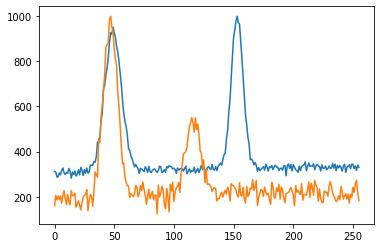

In [10]:
plt.plot(dataset_x[100][0])
plt.plot(dataset_x[101][0])

# Define the custom loss func and model

In [11]:
'''
# IoU soft
note: "hard" probabilistic IoU calculation is not differentiable, 
so be sure to use soft probabilistic loss func
'''
class IoU_soft(nn.Module):
  def __init__(self, thresh:float=0.5, smooth:float = 0.0, alpha: float = 0.5):
    super().__init__()
    self.thresh = thresh
    self.smooth = smooth
    self.alpha = alpha

  def forward(self, inputs: torch.Tensor, targets:torch.Tensor, weights: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    - alpha: a parameter that sharpen the thresholding.
      if alpha = 1 -> thresholded input is the same as raw input.
    '''
    alpha = self.alpha
    threshold = self.thresh
    smooth = self.smooth

    inputs = inputs**alpha / (inputs**alpha + (1 - inputs)**alpha)
    # inputs = torch.where(thresholded_inputs < threshold, 0, 1)

    # thresholded_inputs = torch.where(thresholded_inputs < threshold, 0, 1)
    # inputs = (inputs + thresholded_inputs) - inputs.detach()

    batch_size = inputs.shape[0]

    # instead of hard prob calc: intersect = torch.logical_and(outputs, labels)
    intersect_tensor = (inputs * targets).view(batch_size, -1)
    intersect = intersect_tensor.sum(-1)

    # insetad of using the hard prob: union = torch.logical_or(outputs, labels)   
    union_tensor = torch.max(inputs, targets).view(batch_size, -1)
    union = union_tensor.sum(-1)

    iou = (intersect + smooth) / (union + smooth)  # We smooth our devision to avoid 0/0
    iou_score = iou.mean()

    return 1 - iou_score

class MLC(nn.Module):
  def __init__(self, kn_size:int, init_kn: Tensor=None):
    super().__init__()
    self.init_kn = init_kn
    if kn_size % 2 == 1:
      padding_num = int((kn_size-1)/2)
      print(kn_size, padding_num)
    else:
      kn_size = kn_size + 1
      padding_num = int((kn_size-1)/2)
      print(kn_size, padding_num)
    self.conv1 = nn.Conv1d(1, 1, kernel_size=kn_size, stride=1, padding=padding_num)
    if init_kn is not None:
      self.conv1.weight = nn.Parameter(init_kn.expand(1,1,-1).contiguous())
    self.net = nn.Sequential(
        self.conv1,
        nn.Softmax(2)
        # as of now, it would increase the prediction accuracy to get rid of the softmax layer.
    )
  def forward(self, x):
    return self.net(x)

def kn_initializer(length: int,sigma: float =1.0, amp: float =1.0):
  if length % 2 == 0:
    length += 1
  x = np.arange(-length/2 + 1/2, length/2 + 1/2, 1)
  mother= np.exp(-np.power(x,2)/np.power(sigma, 2))
  mother = amp * mother
  return torch.Tensor(mother)

# Learning and evaluation of the learned conv kernel

65 32


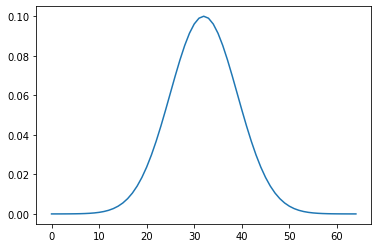

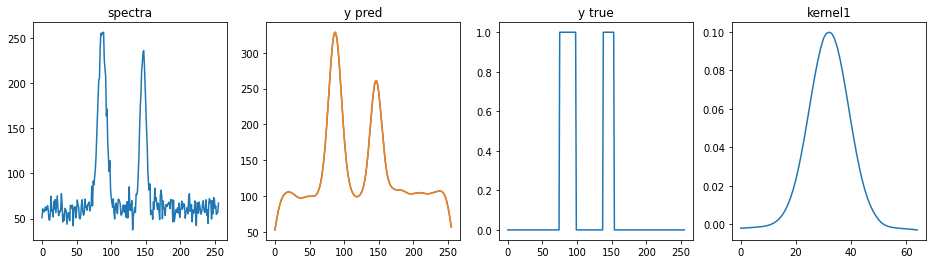

epoch 0:  train loss: 0.9027820529760285


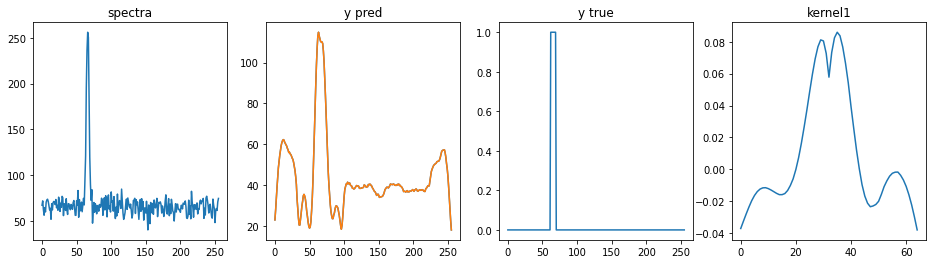

epoch 100:  train loss: 0.897861781565338


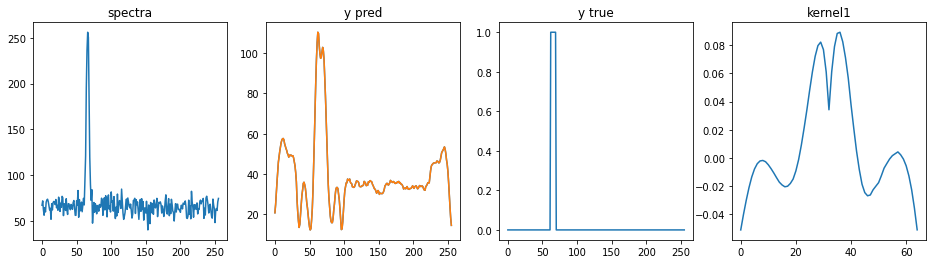

epoch 200:  train loss: 0.897704795936444


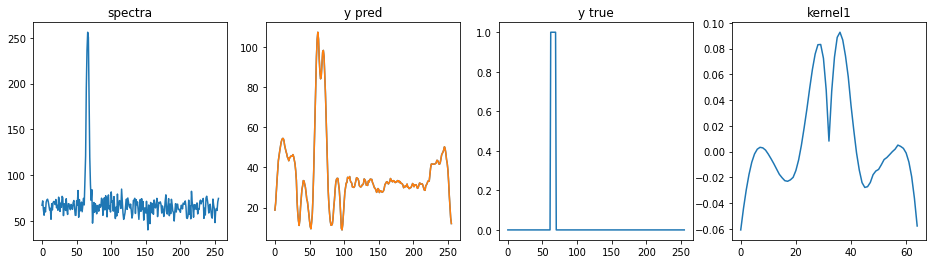

epoch 300:  train loss: 0.8975181076670055


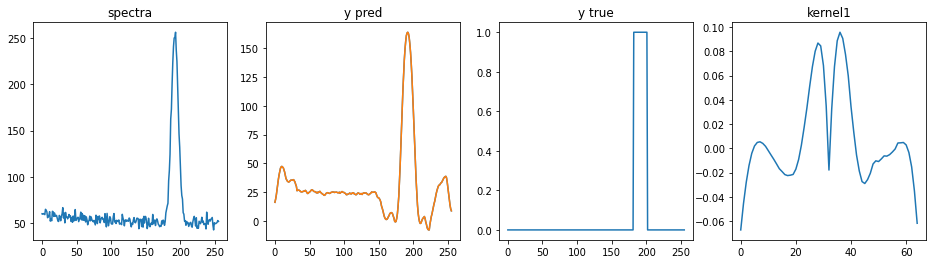

epoch 400:  train loss: 0.897324176616358


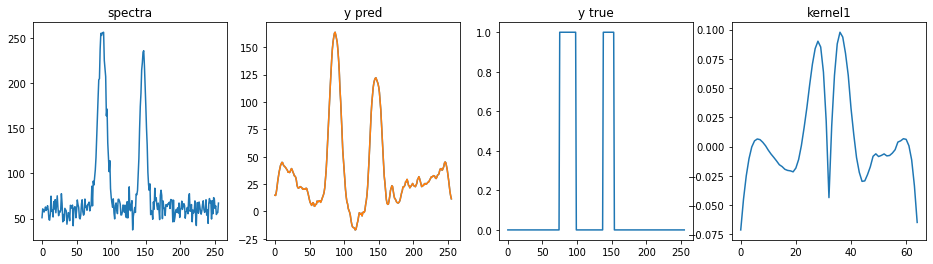

epoch 500:  train loss: 0.8973929264297175


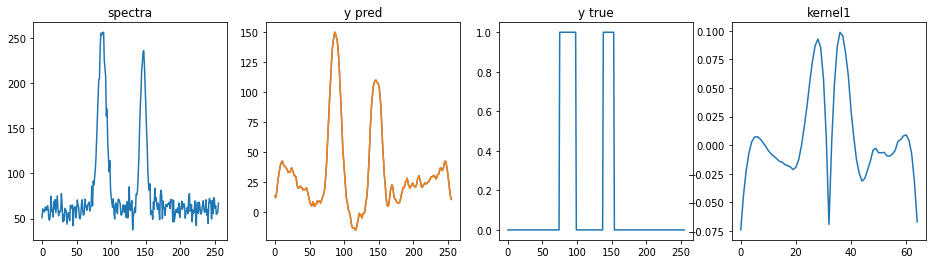

epoch 600:  train loss: 0.8973881818930428


In [14]:
kn_size = 64
epochs = 1000

init_kn = kn_initializer(kn_size, sigma=10, amp=0.1)
model = MLC(kn_size = kn_size, init_kn=init_kn)
opt = optim.Adadelta(model.parameters(), lr=1e-1)

init_kernel = model.state_dict()["net.0.weight"][0][0].detach().numpy()
plt.plot(init_kernel)

model.to(device)
criterion = IoU_soft(alpha=1, smooth=0.1)

train_loss_arr, val_loss_arr = [], []
for e in range(epochs):
  model.train()
  train_loss, val_loss, acc = 0., 0., 0.,
  for x, y in train_set.as_numpy_iterator():
    opt.zero_grad()
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    x = x.to(device)
    y = y.to(device)
    model.train()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    opt.step()
    train_loss += loss.item()
  train_loss /= len(train_set)
  train_loss_arr.append(train_loss)

  for x, y in val_set.as_numpy_iterator():
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    x = x.to(device)
    y = y.to(device)
    model.eval()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    val_loss += loss.item()
  val_loss /= len(val_set)
  val_loss_arr.append(val_loss)

  if e % 100 == 0:
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].plot(x.to("cpu")[0][0])
    axs[0].set_title("spectra")
    axs[1].plot(y_pred.to("cpu")[0][0].detach().numpy())
    axs[1].set_title("y pred")
    y_pred = y_pred**criterion.alpha/(y_pred**criterion.alpha + (1-y_pred)**criterion.alpha)
    axs[1].plot(y_pred.to("cpu")[0][0].detach().numpy())
    axs[2].plot(y.to("cpu")[0])
    axs[2].set_title("y true")
    axs[3].plot(model.state_dict()["net.0.weight"][0][0].to("cpu").numpy())
    axs[3].set_title("kernel1")
    # axs[4].plot(model.state_dict()["2.weight"][0][0].to("cpu").numpy())
    # axs[4].set_title("kernel2")
    plt.show()

    print(f"epoch {e}:  train loss: {train_loss}")

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(train_loss_arr, label="train loss")
axs[0].plot(val_loss_arr, label="val loss")
axs[0].set_title("loss over epochs")
axs[1].plot(init_kernel, label="init kernel")
axs[1].plot(model.state_dict()["net.0.weight"][0][0].to("cpu").numpy(), label="trained kernel")
axs[1].set_title("Initial kernel& Trained kernel")
axs[1].legend()
plt.show()

## nn.Softmax(dim=?)

if you want to apply softmax calculation on each input data(spectra), then dim=-1 or 2 is good!
(this holds true towards LogSoftmax too)

In [5]:
test_tensor = torch.tensor([[[1.0,0,0, -1]],
                            [[1,0,0, -1]],
                            [[-1,-1,-1, -1]],
                            [[1,0,0, -1]],
                            [[2,0,0, -1]],
                            ])

#test_tensor shape: 5, 1, 4
m = nn.LogSoftmax(dim=-1)
test_tensor = m(test_tensor)
print(test_tensor)
print(test_tensor.shape)

# if you want to apply softmax calculation on each input data(spectra), then dim=-1 or 2 is good!

tensor([[[-0.6265, -1.6265, -1.6265, -2.6265]],

        [[-0.6265, -1.6265, -1.6265, -2.6265]],

        [[-1.3863, -1.3863, -1.3863, -1.3863]],

        [[-0.6265, -1.6265, -1.6265, -2.6265]],

        [[-0.2780, -2.2780, -2.2780, -3.2780]]])
torch.Size([5, 1, 4])
